# Figure 3

In [129]:
options(warn=-1)

In [130]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
        
            # Seurat 
            library(Seurat), 

            # TradeSeq
            library(tradeSeq),

            # Data 
            library(tidyverse), 
            library(data.table), 

            # miloR
            library(miloR), 
            library(ggbeeswarm), 

            # Plotting 
            library(ggplot2), 
            library(patchwork), 
            library(cowplot), 
            library(ComplexHeatmap), 

            # Pyhton compatibility
            library(reticulate)

        )
    )
)

In [131]:
# Configure reticulate 
# use_condaenv(condaenv="p.3.10.16-FD20200109SPLENO", conda="/nobackup/peer/fdeckert/miniconda3/bin/conda", required=NULL)
# py_config()

In [132]:
random_seed <- 42
set.seed(random_seed)

In [133]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [134]:
# Source
source("bin/so_pl.R")
source("bin/dp_feature.R")
source("bin/dea_pl.R")
source("bin/tradeseq_pl.R")
source("bin/tradeseq_pp.R")
source("bin/reactome.R")

In [135]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=4)) # From project global source()

# Load reference data 

In [136]:
tf <- read.table("/research/peer/fdeckert/reference/animaltfdb/Mus_musculus_TF.txt")[[2]]

lr <- CellChat::CellChatDB.mouse[[1]] %>% dplyr::select(pathway_name, ligand, receptor.symbol, receptor.family, annotation) %>% dplyr::filter(annotation %in% c("Cell-Cell Contact", "Secreted Signaling", "ECM-Receptor")) %>% 
    separate_rows(receptor.symbol, sep=", ") %>% dplyr::distinct() %>%
    separate_rows(ligand, sep=", ") %>% dplyr::distinct() %>% 
    dplyr::rename(pathway=pathway_name, receptor=receptor.symbol, family=receptor.family)

# Import scRNAseq data 

In [137]:
so <- readRDS("data/scRNAseq/object/pp_1.rds")
so <- NormalizeData(so)

Normalizing layer: counts



In [212]:
colnames(so@meta.data)

[1] "orig.ident"                  "nCount_RNA"                 
 [3] "nFeature_RNA"                "run_path"                   
 [5] "sample_dir"                  "facility"                   
 [7] "lib_assay"                   "facs"                       
 [9] "infection"                   "dpi"                        
[11] "sample_rep"                  "genotype"                   
[13] "sex"                         "age"                        
[15] "sample_group"                "sample_group_rep"           
[17] "sample_name"                 "hto_label"                  
[19] "dm_hto"                      "dm_prob"                    
[21] "dm_class"                    "hd_logfc"                   
[23] "hd_class"                    "cell_id"                    
[25] "label_main_immgen"           "delta_score_main_immgen"    
[27] "label_fine_immgen"           "delta_score_fine_immgen"    
[29] "label_main_haemopedia"       "delta_score_main_haemopedia"
[31] "S_score"                     "G2M_score"                  
[33] "n_genes_by_counts"           "log1p_n_genes_by_counts"    
[35] "total_counts"                "log1p_total_counts"         
[37] "total_counts_MT"             "log1p_total_counts_MT"      
[39] "pct_counts_MT"               "total_counts_HB"            
[41] "log1p_total_counts_HB"       "pct_counts_HB"              
[43] "total_counts_RP"             "log1p_total_counts_RP"      
[45] "pct_counts_RP"               "total_counts_XIST"          
[47] "log1p_total_counts_XIST"     "pct_counts_XIST"            
[49] "solo_pred_singlet"           "solo_pred_doublet"          
[51] "solo_label"                  "S_score_scale"              
[53] "G2M_score_scale"             "_scvi_batch"                
[55] "_scvi_labels"                "leiden"                     
[57] "leiden_new"                  "celltype_leiden"            
[59] "celltype_low"                "leiden_tmp"                 
[61] "celltype_high"               "dpt_pseudotime"

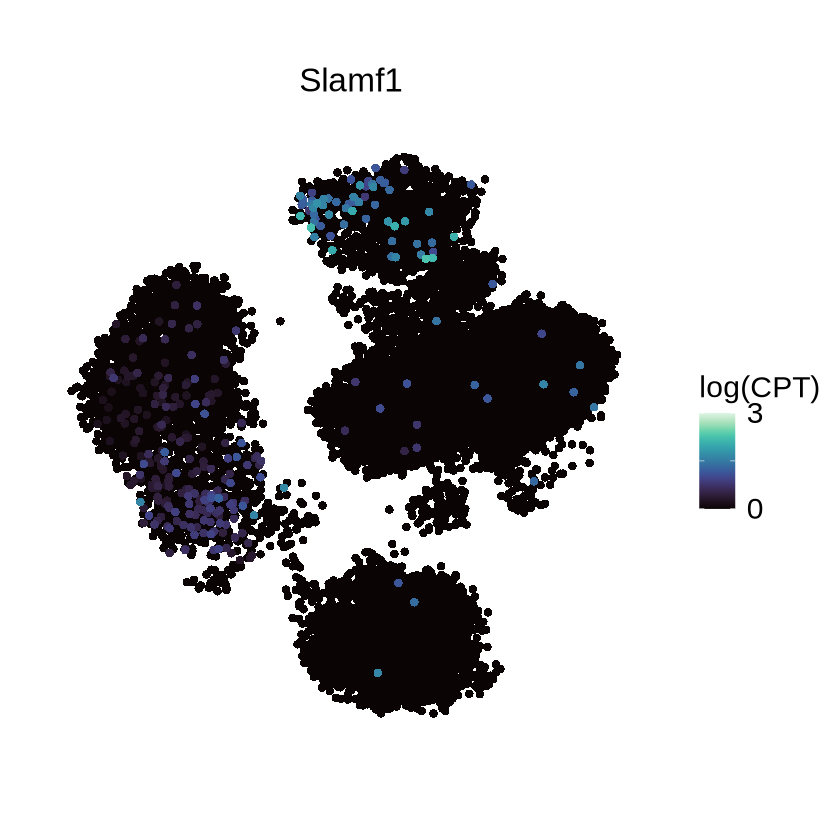

[[1]]

[[2]]

[[3]]


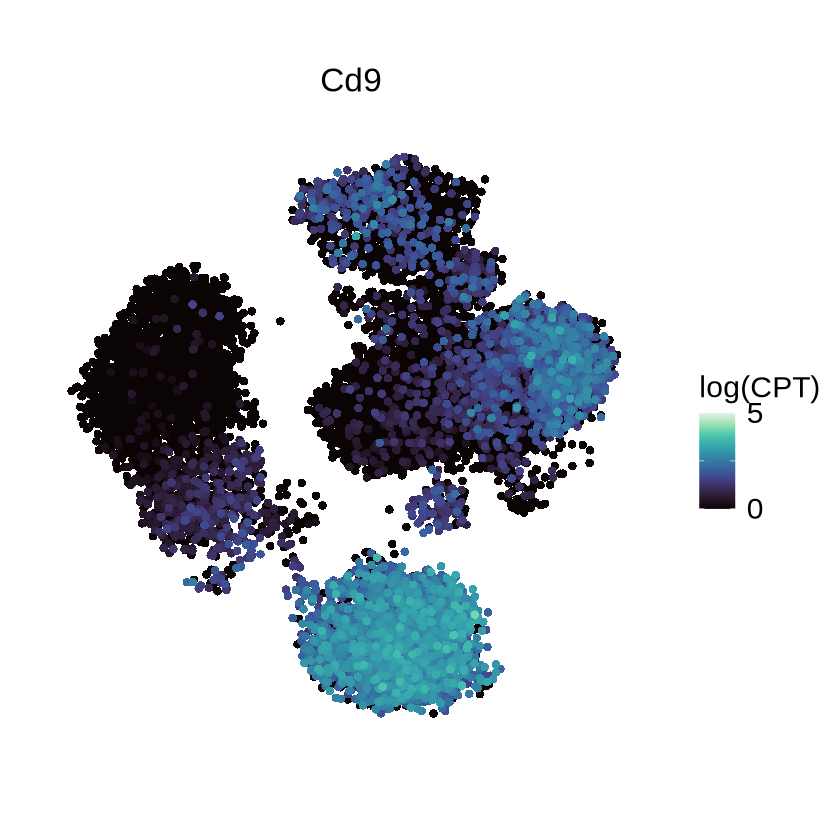

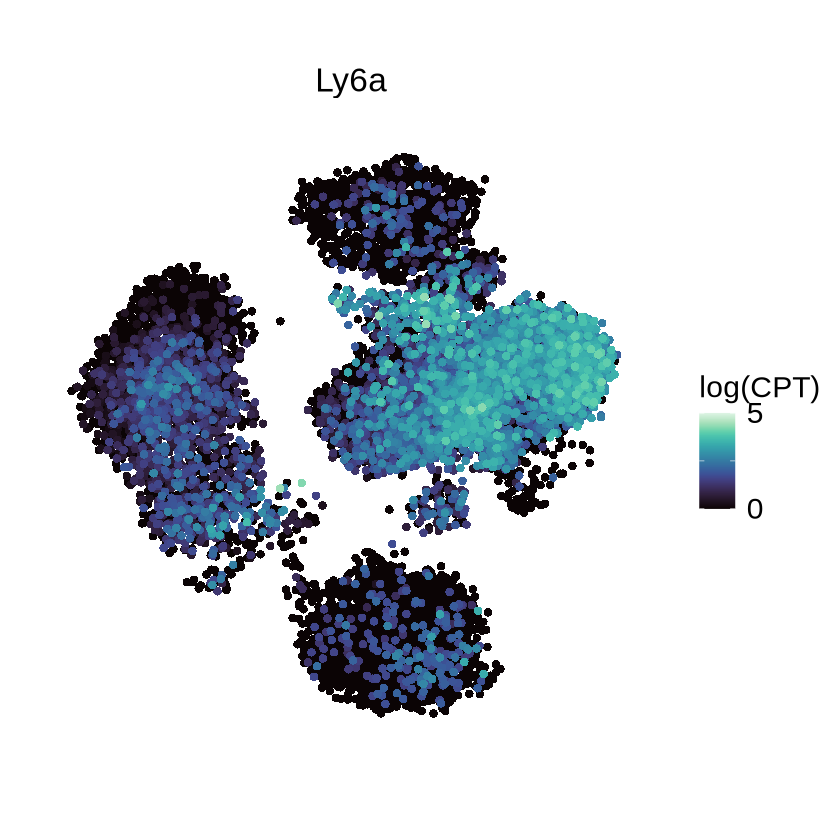

In [214]:
genes <- c("Slamf1", "Cd9", "Ly6a") 
lapply(genes, function(i){

    fplot(so[, so$infection=="CpG"], features = i, slot="data")
}
      )

# UMAP leiden celltype low

In [138]:
dp_1 <- dplot(so, group_by="celltype_low", alpha=1.0, pt_size=0.25, shuffle=TRUE, size_select=4) + 

    scale_color_manual(values=color$celltype_low) + 
    scale_fill_manual(values=color$celltype_low) + 
    guides(color=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0, keyheight=0.25, default.unit="cm")) + 
    theme(
    
        legend.text.align=0
    
    ) 

In [139]:
pdf("result/figures/figure_3/umap_celltype_low.pdf", width=3.5, height=2.5)

dp_1

dev.off()

pdf 
  2

# Barplot celltype ratio  

In [140]:
so$celltype_high <- ifelse(so$celltype_low %in% c("MEP", "Proerythroblast", "Erythroblast"), "E", ifelse(so$celltype_low %in% c("MegP", "GMP", "NeuP", "BasoP", "MastP"), "P", "M"))

In [141]:
so$sample_group_rep <- so$sample_group
so$sample_group_rep <- factor(so$sample_group_rep, levels=c("IFNAR_fl_Baseline_D0", "IFNAR_fl_LysM_cre_Baseline_D0", "IFNAR_fl_CpG_D1",  "IFNAR_fl_LysM_cre_CpG_D1", "IFNAR_fl_CpG_D3", "IFNAR_fl_LysM_cre_CpG_D3"))

In [142]:
bp_1 <- ggplot(so@meta.data[so$celltype_high=="E", ], aes(x=sample_group_rep, fill=celltype_low)) + 
    geom_bar(position="fill", width=0.8, color="black", size=0.1) + 
    scale_fill_manual(values=color$celltype_low) + 
    ggtitle("") + xlab("") + ylab("Celltype [ratio]") + 
    facet_wrap(~celltype_high, scales="free", ncol=1) + 
    scale_x_discrete(labels=c("+/+ Ctl", "cre/+ Ctl", "+/+ D1", "cre/+ D1", "+/+ D3", "cre/+ D3")) + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

bp_2 <- ggplot(so@meta.data[so$celltype_high=="P", ], aes(x=sample_group_rep, fill=celltype_low)) + 
    geom_bar(position="fill", width=0.8, color="black", size=0.1) + 
    scale_fill_manual(values=color$celltype_low) + 
    ggtitle("") + xlab("") + ylab("Celltype [ratio]") + 
    facet_wrap(~celltype_high, scales="free", ncol=1) + 
    scale_x_discrete(labels=c("+/+ Ctl", "cre/+ Ctl", "+/+ D1", "cre/+ D1", "+/+ D3", "cre/+ D3")) + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

bp_3 <- ggplot(so@meta.data[so$celltype_high=="M", ], aes(x=sample_group_rep, fill=celltype_low)) + 
    geom_bar(position="fill", width=0.8, color="black", size=0.1) + 
    scale_fill_manual(values=color$celltype_low) + 
    ggtitle("") + xlab("") + ylab("Celltype [ratio]") + 
    facet_wrap(~celltype_high, scales="free", ncol=1) + 
    scale_x_discrete(labels=c("+/+ Ctl", "cre/+ Ctl", "+/+ D1", "cre/+ D1", "+/+ D3", "cre/+ D3")) + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [143]:
pdf("result/figures/figure_3/bp_celltype_low.pdf", width=2, height=4)

gridExtra::grid.arrange(

    bp_1 %>% egg::set_panel_size(., width=unit(6*0.30, "cm"), height=unit(2.0, "cm")),
    bp_2 %>% egg::set_panel_size(., width=unit(6*0.30, "cm"), height=unit(2.0, "cm")),
    bp_3 %>% egg::set_panel_size(., width=unit(6*0.30, "cm"), height=unit(2.0, "cm")), ncol=1
        
)

dev.off()

pdf 
  2

# Celltype marker genes

In [144]:
marker_genes=data.frame(

    celltype=c(
        
        "Prog.", "Prog.", "Prog.", "Prog.", "Prog.",

        "NeuP", 
               
        "Baso.", "Baso.", "Baso.", "Baso.", 
               
        "Mast", "Mast", 

        "MegP", "MegP", 
               
        "Erythroid", "Erythroid", "Erythroid", "Erythroid", "Erythroid", "Erythroid", "Erythroid", "Erythroid", "Erythroid", 
               
        "Mono.", "Mono.", "Mono.", "Mono.", 
               
        "RPM", "RPM", "RPM", 
               
        "cDC", "cDC", "cDC", "cDC", "cDC", "cDC", "cDC"
               
    ), 
    
    genes=c(
        
        "Hlf", "Cd34", "Kit", "Meis1", "Spi1",  

        "Elane", 
            
        "Cebpa", "Mcpt8", "Clec12a", "Itga2", 
            
        "Mcpt4", "Cma1", 

        "Pf4", "Itga2b",
            
        "Gata2", "Gata1", "Klf1", "Icam4", "Epor", "Sox6", "Tfrc", "Alas2", "Slc4a1",
            
        "Ly6c2", "Ccr2", "Cx3cr1", "Itgam",
            
        "Adgre1", "Spic", "Cd163",  
            
        "Sirpa", "Flt3", "Xcr1", "Cd8a", "Cd4", "Cd209a", "Ccr7"
    
    )
    
)

In [145]:
dp_1 <- dp_feature(so, marker_genes$genes, group_by="celltype_low", group_by_order=rev(levels(so$celltype_low)), split=marker_genes$celltype, split_order=unique(marker_genes$celltype), range_max=2.5) + 

    scale_y_discrete(labels=rev(levels(so$celltype_low))) + theme_global_set(4) + 

        theme(
            legend.position="bottom", 
            panel.spacing=unit(0.1, "lines"), 
            axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, face="italic"),
            axis.text.y=element_text(angle=0, vjust=0.5, hjust=1), 
            strip.text.x=element_text(angle=90, vjust=0.5, hjust=0), 
            strip.text=element_text(margin=margin(0.1, 0.1, 0.1, 0.1, "lines")), 
            strip.background=element_rect(fill="transparent", color=NA), 
            legend.key.size=unit(0.25, "cm"), 
            legend.key.height=unit(0.25, "cm"), 
            legend.key.width=unit(0.25, "cm")
            
        )

`summarise()` has grouped output by 'celltype_low'. You can override using the
`.groups` argument.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [146]:
pdf("result/figures/figure_3/dp_celltype_low_marker_genes.pdf", width=4.0, height=3.2)

dp_1

dev.off()

pdf 
  2

# UMAP erytime

In [147]:
dpt <- read.csv("result/pseudotime/ery_dpt.csv", row.names=1)
so <- AddMetaData(so, dpt)

In [148]:
fp_1 <- fplot(so, features="dpt_pseudotime", pt_size=0.25, option="F", size_select=4)
fp_1[[1]]$data <- fp_1[[1]]$data[!is.na(fp_1[[1]]$data$feature), ]

In [149]:
pdf("result/figures/figure_3/umap_erytime.pdf", width=3.5, height=2.5)

gridExtra::grid.arrange(
    
    fp_1 %>% egg::set_panel_size(., width=unit(4.5, "cm"), height=unit(4.5, "cm"))

)

dev.off()

pdf 
  2

# Import erythroid lineage fitgam and make contrasts

In [150]:
tradeseq_res <- readRDS("result/lineage/tradeseq_res_2.rds")
fitgam <- tradeseq_res[["fitgam"]]
ptpg <- tradeseq_res[["ptpg"]]

In [151]:
contrast_1 <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1")
ptpg_res_1 <- ptpg[ptpg[["contrast"]]==paste0(contrast_1, collapse=":"), ]

contrast_2 <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D3")
ptpg_res_2 <- ptpg[ptpg[["contrast"]]==paste0(contrast_2, collapse=":"), ]

contrast_3 <- c("IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
ptpg_res_3 <- ptpg[ptpg[["contrast"]]==paste0(contrast_3, collapse=":"), ]

In [152]:
genes_ptcg_1 <- ptpg_res_1[ptpg_res_1$ptpg_class=="Canonical", ][["gene"]]
genes_ptpg_res_1 <- ptpg_res_1[ptpg_res_1$ptpg_class!="Canonical", ][["gene"]]

genes_ptcg_2 <- ptpg_res_2[ptpg_res_2$ptpg_class=="Canonical", ][["gene"]]
genes_ptpg_2 <- ptpg_res_2[ptpg_res_2$ptpg_class!="Canonical", ][["gene"]]

genes_ptcg_3 <- ptpg_res_3[ptpg_res_3$ptpg_class=="Canonical", ][["gene"]]
genes_ptpg_3 <- ptpg_res_3[ptpg_res_3$ptpg_class!="Canonical", ][["gene"]]

# Transcription factor heatmap of smoothed expression 

## Load pruned graph TF and target gens 

In [153]:
reg <- read.csv("result/scenic/scRNAseq/res_1/reg.csv", row.names=1, skip=1)
colnames(reg) <- c("TF", "target_genes")

In [154]:
tf <- c("Nfkb1", "Myb", "Fli1", "Gata2", "E2f3", "Bcl11a", "Myc", "Ikzf1", "Zfp148", "Irf8", "Irf1", "Irf7", "Stat1", "Stat2", "Stat3", "Bclaf1", "E2f4", "Gata1", "E2f7", "Tal1", "E2f1", "Mybl2", "Klf1", "E2f8", "Klf3", "E2f2")

## PTCG Ctl (+/+) and D1 (+/+) and D3 (+/+)

In [155]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [156]:
genes_select <- intersect(ptpg_res_1[ptpg_res_1$ptpg_class=="Canonical", ]$gene, ptpg_res_2[ptpg_res_2$ptpg_class=="Canonical", ]$gene) # Union of response genes D1 (+/+) and D3 (+/+)
genes_select <- genes_select[!genes_select %in% ptpg_res_3[ptpg_res_3$ptpg_class != "Canonical", ]$gene] # Remove genes that are different perturbed between D1 (+/+) and D3 (+/+)

In [157]:
pt_split_ptcg <- pt_split(fitgam, genes_select, contrast_vec)

In [158]:
tf_tg_mat_ptcg <- reg[reg$target_genes %in% names(pt_split_ptcg), ]
tf_tg_mat_ptcg <- tf_tg_pp(tf_tg_mat_ptcg)
tf_tg_mat_ptcg <- tf_tg_prune(tf_tg_mat_ptcg, pt_split_ptcg, tf_ratio=0, tf_sum=0, tf_fill=TRUE)
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, tf]

In [159]:
pt_tf_hm_1 <- pt_tf_hm(tf_tg_mat_ptcg, row_split=pt_split_ptcg, height=200, fontsize_select=2, cluster_rows=FALSE, cluster_columns=FALSE, use_raster=FALSE)
pt_hm_1 <- pt_hm(fitgam, names(pt_split_ptcg), "IFNAR_fl_Baseline_D0", contrast_vec, 50, color_mat[1], row_split=pt_split_ptcg, width=0.75, height=200, fontsize_select=2, use_raster=TRUE)
pt_hm_2 <- pt_hm(fitgam, names(pt_split_ptcg), "IFNAR_fl_CpG_D1", contrast_vec, 50, color_mat[2], row_split=pt_split_ptcg, width=0.75, height=200, fontsize_select=2, use_raster=TRUE)
pt_hm_3 <- pt_hm(fitgam, names(pt_split_ptcg), "IFNAR_fl_CpG_D3", contrast_vec, 50, color_mat[3], row_split=pt_split_ptcg, width=0.75, height=200, fontsize_select=2, use_raster=TRUE)

In [160]:
row_genes <- c(
    
    "Meis1", "Klf1", "Tal1", "Gata1", "Gata2", "Epor", "Tfrc", "Alas2", 
    "Mki67", "Pcna", "Top2a", 
    "Pkm", "Cpt1a", "Acadm", "Sdha", "Ndufs1", "G6pdx", "Taldo1", 
    grep("Isg|Ifi|Irf|Socs|Smad|Nfkb|Stat|Icam|Smad|Bmp", genes_select, value=TRUE), 
    grep("Tlr[0-9]+|Nlrp|Nlrc|Nod|Ddx58|Ifih1|Clec[0-9]+|Fc[grme]|Ifnar|Ifngr|Ifnlr|Il[0-9]+r[a-z]?|Ccr[0-9]+|Cxcr[0-9]+|Cx3cr1|Xcr1|Cd3|Cd79|Klra|Klrb|Klrc|Klrd|Klre|Klrf|Klrg|Kit|Cd[0-9]+[a-zA-Z]?|Tgfb[123]|Tgfbr[123]|Smad[1-9]|Bmp[0-9]+|Bmpr1a|Bmpr1b|Bmpr2|Acvr1|Acvr2a|Acvr2b|Gdf[0-9]+|Kitl|Kit|Nr3c1|Ptch[12]|Smo|Cdon|Boc|Gas1", genes_select, value=TRUE)

)

row_genes <- row_genes[row_genes %in% rownames(pt_tf_hm_1@matrix)]

row_anno <- rowAnnotation(
    
    labels=anno_mark(
        
        at=which(rownames(pt_tf_hm_1@matrix) %in% row_genes),
        labels=rownames(pt_tf_hm_1@matrix)[which(rownames(pt_tf_hm_1@matrix) %in% row_genes)],
        side="left", 
        labels_gp=gpar(fontsize=6), 
        link_width=unit(3, "mm")
    
    )

)

In [161]:
pdf("result/figures/figure_3/hm_tf_ptcg_ctl_d1_d3.pdf", width=10, height=10)

draw(row_anno + pt_tf_hm_1 + pt_hm_1 + pt_hm_2 + pt_hm_3)

dev.off()

pdf 
  2

## PTPG D1 (+/+) or D3 (+/+) UP vs Ctl (+/+)

In [162]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [163]:
genes_select <- union(ptpg_res_1[ptpg_res_1$ptpg_class=="IFNAR_fl_CpG_D1", ]$gene, ptpg_res_2[ptpg_res_2$ptpg_class=="IFNAR_fl_CpG_D3", ]$gene) # Union of response genes UP D1 (+/+) and D3 (+/+) vs Ctl (+/+)

In [164]:
pt_split_ptpg <- pt_split(fitgam, genes_select, contrast_vec)

In [165]:
tf_tg_mat_ptcg <- reg[reg$target_genes %in% names(pt_split_ptpg), ]
tf_tg_mat_ptcg <- tf_tg_pp(tf_tg_mat_ptcg)
tf_tg_mat_ptcg <- tf_tg_prune(tf_tg_mat_ptcg, pt_split_ptpg, tf_ratio=0, tf_sum=0, tf_fill=TRUE)
tf_tg_mat_ptcg[tf[!tf %in% colnames(tf_tg_mat_ptcg)]] <- 0
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, tf]

In [166]:
pt_tf_hm_1 <- pt_tf_hm(tf_tg_mat_ptcg, row_split=pt_split_ptpg, height=50, fontsize_select=2, cluster_rows=FALSE, cluster_columns=FALSE, use_raster=FALSE)
pt_hm_1 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_Baseline_D0", contrast_vec, 50, color_mat[1], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_2 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D1", contrast_vec, 50, color_mat[2], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_3 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D3", contrast_vec, 50, color_mat[3], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)

In [167]:
row_genes <- c(
    
    "Meis1", "Klf1", "Tal1", "Gata1", "Gata2", "Epor", "Tfrc", "Alas2", 
    "Mki67", "Pcna", "Top2a", 
    "Pkm", "Cpt1a", "Acadm", "Sdha", "Ndufs1", "G6pdx", "Taldo1", 
    grep("Isg|Ifi|Irf|Socs|Smad|Nfkb|Stat|Icam|Smad|Bmp", genes_select, value=TRUE), 
    grep("Tlr[0-9]+|Nlrp|Nlrc|Nod|Ddx58|Ifih1|Clec[0-9]+|Fc[grme]|Ifnar|Ifngr|Ifnlr|Il[0-9]+r[a-z]?|Ccr[0-9]+|Cxcr[0-9]+|Cx3cr1|Xcr1|Cd3|Cd79|Klra|Klrb|Klrc|Klrd|Klre|Klrf|Klrg|Kit|Cd[0-9]+[a-zA-Z]?|Tgfb[123]|Tgfbr[123]|Smad[1-9]|Bmp[0-9]+|Bmpr1a|Bmpr1b|Bmpr2|Acvr1|Acvr2a|Acvr2b|Gdf[0-9]+|Kitl|Kit|Nr3c1|Ptch[12]|Smo|Cdon|Boc|Gas1", genes_select, value=TRUE)

)

row_genes <- row_genes[row_genes %in% rownames(pt_tf_hm_1@matrix)]

row_anno <- rowAnnotation(
    
    labels=anno_mark(
        at=which(rownames(pt_tf_hm_1@matrix) %in% row_genes),
        labels=rownames(pt_tf_hm_1@matrix)[which(rownames(pt_tf_hm_1@matrix) %in% row_genes)],
        side="left", 
        labels_gp=gpar(fontsize=6), 
        link_width=unit(3, "mm")
    
    )

)

In [168]:
pdf("result/figures/figure_3/hm_tf_ptpg_d1_or_d3_up_vs_ctl.pdf", width=6, height=10)

draw(row_anno + pt_tf_hm_1 + pt_hm_1 + pt_hm_2 + pt_hm_3)

dev.off()

pdf 
  2

## PTPG D1 (+/+) or D3 (+/+) DOWN vs Ctl (+/+)

In [169]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [170]:
genes_select <- union(ptpg_res_1[ptpg_res_1$ptpg_class=="IFNAR_fl_Baseline_D0", ]$gene, ptpg_res_2[ptpg_res_2$ptpg_class=="IFNAR_fl_Baseline_D0", ]$gene) # Union of response genes DOWN D1 (+/+) and D3 (+/+) vs Ctl (+/+)

In [171]:
pt_split_ptpg <- pt_split(fitgam, genes_select, contrast_vec)

In [172]:
tf_tg_mat_ptcg <- reg[reg$target_genes %in% names(pt_split_ptpg), ]
tf_tg_mat_ptcg <- tf_tg_pp(tf_tg_mat_ptcg)
tf_tg_mat_ptcg <- tf_tg_prune(tf_tg_mat_ptcg, pt_split_ptpg, tf_ratio=0, tf_sum=0, tf_fill=TRUE)
tf_tg_mat_ptcg[tf[!tf %in% colnames(tf_tg_mat_ptcg)]] <- 0
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, tf]

In [173]:
pt_tf_hm_1 <- pt_tf_hm(tf_tg_mat_ptcg, row_split=pt_split_ptpg, height=50, fontsize_select=2, cluster_rows=FALSE, cluster_columns=FALSE, use_raster=FALSE)
pt_hm_1 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_Baseline_D0", contrast_vec, 50, color_mat[1], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_2 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D1", contrast_vec, 50, color_mat[2], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_3 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D3", contrast_vec, 50, color_mat[3], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)

In [174]:
row_genes <- rownames(pt_tf_hm_1@matrix)

row_anno <- rowAnnotation(
    
    labels=anno_mark(
        at=which(rownames(pt_tf_hm_1@matrix) %in% row_genes),
        labels=rownames(pt_tf_hm_1@matrix)[which(rownames(pt_tf_hm_1@matrix) %in% row_genes)],
        side="left", 
        labels_gp=gpar(fontsize=6), 
        link_width=unit(3, "mm")
    
    )

)

In [175]:
pdf("result/figures/figure_3/hm_tf_ptpg_d1_or_d3_down_vs_ctl.pdf", width=6, height=10)

draw(row_anno + pt_tf_hm_1 + pt_hm_1 + pt_hm_2 + pt_hm_3)

dev.off()

pdf 
  2

## PTPG D1 (+/+) UP vs D3 (+/+) 

In [176]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [177]:
genes_select <- ptpg_res_3[ptpg_res_3$ptpg_class=="IFNAR_fl_CpG_D1", ]$gene # Genes up on D1 (+/+) vs D3 (+/+)

In [178]:
pt_split_ptpg <- pt_split(fitgam, genes_select, contrast_vec)

In [179]:
tf_tg_mat_ptcg <- reg[reg$target_genes %in% names(pt_split_ptpg), ]
tf_tg_mat_ptcg <- tf_tg_pp(tf_tg_mat_ptcg)
tf_tg_mat_ptcg <- tf_tg_prune(tf_tg_mat_ptcg, pt_split_ptpg, tf_ratio=0, tf_sum=0, tf_fill=TRUE)
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, colnames(tf_tg_mat_ptcg) %in% tf]

In [180]:
tf_fill <- setdiff(tf, colnames(tf_tg_mat_ptcg))
tf_tg_mat_ptcg[, tf_fill] <- 0
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, tf, drop=FALSE]

In [181]:
pt_tf_hm_1 <- pt_tf_hm(tf_tg_mat_ptcg, row_split=pt_split_ptpg, height=50, fontsize_select=2, cluster_rows=FALSE, cluster_columns=FALSE, use_raster=FALSE)
pt_hm_1 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_Baseline_D0", contrast_vec, 50, color_mat[1], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_2 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D1", contrast_vec, 50, color_mat[2], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_3 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D3", contrast_vec, 50, color_mat[3], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)

In [182]:
row_genes <- rownames(pt_tf_hm_1@matrix)

row_anno <- rowAnnotation(
    
    labels=anno_mark(
        at=which(rownames(pt_tf_hm_1@matrix) %in% row_genes),
        labels=rownames(pt_tf_hm_1@matrix)[which(rownames(pt_tf_hm_1@matrix) %in% row_genes)],
        side="left", 
        labels_gp=gpar(fontsize=6), 
        link_width=unit(3, "mm")
    
    )

)

In [183]:
pdf("result/figures/figure_3/hm_tf_ptpg_d1_up_vs_d3.pdf", width=6, height=10)

draw(row_anno + pt_tf_hm_1 + pt_hm_1 + pt_hm_2 + pt_hm_3)

dev.off()

pdf 
  2

## PTPG D1 (+/+) DOWN vs D3 (+/+) 

In [184]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [185]:
genes_select <- ptpg_res_3[ptpg_res_3$ptpg_class=="IFNAR_fl_CpG_D3", ]$gene # Genes up on D1 (+/+) vs D3 (+/+)

In [186]:
pt_split_ptpg <- pt_split(fitgam, genes_select, contrast_vec)

In [187]:
tf_tg_mat_ptcg <- reg[reg$target_genes %in% names(pt_split_ptpg), ]
tf_tg_mat_ptcg <- tf_tg_pp(tf_tg_mat_ptcg)
tf_tg_mat_ptcg <- tf_tg_prune(tf_tg_mat_ptcg, pt_split_ptpg, tf_ratio=0, tf_sum=0, tf_fill=TRUE)
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, colnames(tf_tg_mat_ptcg) %in% tf]

In [188]:
tf_fill <- setdiff(tf, colnames(tf_tg_mat_ptcg))
tf_tg_mat_ptcg[, tf_fill] <- 0
tf_tg_mat_ptcg <- tf_tg_mat_ptcg[, tf, drop=FALSE]

In [189]:
pt_tf_hm_1 <- pt_tf_hm(tf_tg_mat_ptcg, row_split=pt_split_ptpg, height=50, fontsize_select=2, cluster_rows=FALSE, cluster_columns=FALSE, use_raster=FALSE)
pt_hm_1 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_Baseline_D0", contrast_vec, 50, color_mat[1], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_2 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D1", contrast_vec, 50, color_mat[2], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)
pt_hm_3 <- pt_hm(fitgam, names(pt_split_ptpg), "IFNAR_fl_CpG_D3", contrast_vec, 50, color_mat[3], row_split=pt_split_ptpg, width=0.75, height=50, fontsize_select=2, use_raster=TRUE)

In [190]:
row_genes <- rownames(pt_tf_hm_1@matrix)

row_anno <- rowAnnotation(
    
    labels=anno_mark(
        at=which(rownames(pt_tf_hm_1@matrix) %in% row_genes),
        labels=rownames(pt_tf_hm_1@matrix)[which(rownames(pt_tf_hm_1@matrix) %in% row_genes)],
        side="left", 
        labels_gp=gpar(fontsize=6), 
        link_width=unit(3, "mm")
    
    )

)

In [191]:
pdf("result/figures/figure_3/hm_tf_ptpg_d1_down_vs_d3.pdf", width=6, height=10)

draw(row_anno + pt_tf_hm_1 + pt_hm_1 + pt_hm_2 + pt_hm_3)

dev.off()

pdf 
  2

# Line plots smoothed expression 

# Stress erythroid marker 

In [223]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [228]:
genes <- c("Kit", "Cd24a", "Tfrc", "Slamf1", "Cd9", "Ly6a")
# genes <- pt_split(fitgam, genes, contrast_vec) %>% names()

In [229]:
lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.5/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})
lp_1 <- lapply(lp_1, function(p) egg::set_panel_size(p, width=unit(2.0, "cm"), height=unit(0.75, "cm")))
lp_1 <- do.call(gridExtra::arrangeGrob, c(lp_1, ncol=10, nrow=ceiling(length(lp_1)/10)))

In [230]:
pdf("result/figures/figure_3/lp_stress_erythroid_marker.pdf", width=10*1.25, height=ceiling(length(lp_1)/10))

grid::grid.draw(lp_1)

dev.off()

pdf 
  2

## PTCG Ctl (+/+) and D1 (+/+) and D3 (+/+)

In [192]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [193]:
genes <- c("Meis1", "Klf1", "Tal1", "Gata1", "Epor", "Tfrc", "Alas2")
genes %in% intersect(genes_ptcg_1, genes_ptcg_2)

lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.0/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})

[1]  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE

In [194]:
pdf("result/figures/figure_3/lp_ptcg_ctl_d1_d3.pdf", width=1.5, height=6)

gridExtra::grid.arrange(
    
    lp_1[[1]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), 
    lp_1[[2]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), 
    lp_1[[3]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), 
    lp_1[[4]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), 
    lp_1[[5]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), 
    lp_1[[6]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")),
    lp_1[[7]] %>% egg::set_panel_size(., width=unit(2.0, "cm"), height=unit(0.75, "cm")), ncol=1
    
)

dev.off()

pdf 
  2

## PTPG D1 (+/+) or D3 (+/+) UP vs Ctl (+/+)

In [195]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [196]:
genes <- union(ptpg_res_1[ptpg_res_1$ptpg_class=="IFNAR_fl_CpG_D1" , ]$gene, ptpg_res_2[ptpg_res_2$ptpg_class=="IFNAR_fl_CpG_D3" , ]$gene)
genes <- pt_split(fitgam, genes, contrast_vec) %>% names()

In [198]:
lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.5/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})
lp_1 <- lapply(lp_1, function(p) egg::set_panel_size(p, width=unit(2.0, "cm"), height=unit(0.75, "cm")))
lp_1 <- do.call(gridExtra::arrangeGrob, c(lp_1, ncol=10, nrow=ceiling(length(lp_1)/10)))

In [199]:
pdf("result/figures/figure_3/lp_ptpg_d1_or_d3_up_vs_ctl.pdf", width=10*1.25, height=ceiling(length(lp_1)/10))

grid::grid.draw(lp_1)

dev.off()

pdf 
  2

## PTPG D1 (+/+) or D3 (+/+) DOWN vs Ctl (+/+)

In [205]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [206]:
genes <- union(ptpg_res_1[ptpg_res_1$ptpg_class=="IFNAR_fl_Baseline_D0" , ]$gene, ptpg_res_2[ptpg_res_2$ptpg_class=="IFNAR_fl_Baseline_D0" , ]$gene)
genes <- pt_split(fitgam, genes, contrast_vec) %>% names()

In [207]:
length(genes)

[1] 46

In [208]:
lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.5/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})
lp_1 <- lapply(lp_1, function(p) egg::set_panel_size(p, width=unit(2.0, "cm"), height=unit(0.75, "cm")))
lp_1 <- do.call(gridExtra::arrangeGrob, c(lp_1, ncol=10, nrow=ceiling(length(lp_1)/10)))

In [209]:
pdf("result/figures/figure_3/lp_ptpg_d1_or_d3_down_vs_ctl.pdf", width=10*1.25, height=ceiling(length(lp_1)/10))

grid::grid.draw(lp_1)

dev.off()

pdf 
  2

## PTPG D1 (+/+) UP vs D3 (+/+) 

In [ ]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [ ]:
genes <- ptpg_res_3[ptpg_res_3$ptpg_class=="IFNAR_fl_CpG_D1" , ]$gene
genes <- pt_split(fitgam, genes, contrast_vec) %>% names()

In [ ]:
lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.5/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})
lp_1 <- lapply(lp_1, function(p) egg::set_panel_size(p, width=unit(2.0, "cm"), height=unit(0.75, "cm")))
lp_1 <- do.call(gridExtra::arrangeGrob, c(lp_1, ncol=10, nrow=ceiling(length(lp_1)/10)))

In [ ]:
pdf("result/figures/figure_3/lp_ptpg_d1_up_vs_d3.pdf", width=10*1.25, height=ceiling(length(lp_1)/10))

grid::grid.draw(lp_1)

dev.off()

## PTPG D1 (+/+) DOWN vs D3 (+/+) 

In [ ]:
contrast_vec <- c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")
color_mat <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]

In [ ]:
genes <- ptpg_res_3[ptpg_res_3$ptpg_class=="IFNAR_fl_CpG_D3" , ]$gene
genes <- pt_split(fitgam, genes, contrast_vec) %>% names()

In [ ]:
lp_1 <- lapply(genes, function(i) {plot_smooth(fitgam, gene=i, point=FALSE, condition_color=color_mat, line_size=unit(1.5/2.141959, "pt"), condition_line_type=TRUE) + annotate("text", x=0.5, y=0, label=i, hjust=0.5, vjust=-1, size=2) + theme(legend.position="none")})
lp_1 <- lapply(lp_1, function(p) egg::set_panel_size(p, width=unit(2.0, "cm"), height=unit(0.75, "cm")))
lp_1 <- do.call(gridExtra::arrangeGrob, c(lp_1, ncol=10, nrow=ceiling(length(lp_1)/10)))

In [ ]:
pdf("result/figures/figure_3/lp_ptpg_d1_down_vs_d3.pdf", width=10*1.25, height=ceiling(length(lp_1)/10))

grid::grid.draw(lp_1)

dev.off()

# Pie chart PT gene counts

In [ ]:
ptpg_class_color <- c("Perturbed"="#7f7f7f", "Canonical"="#AEAEAE")
data <- table(ptpg_res_1 %>% dplyr::mutate(ptpg_class=ifelse(ptpg_class=="Canonical", "Canonical", "Perturbed")) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_1 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
ptpg_class_color <- c("Perturbed"="#7f7f7f", "Canonical"="#AEAEAE")
data <- table(ptpg_res_2 %>% dplyr::mutate(ptpg_class=ifelse(ptpg_class=="Canonical", "Canonical", "Perturbed")) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_2 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
ptpg_class_color <- c("Perturbed"="#7f7f7f", "Canonical"="#AEAEAE")
data <- table(ptpg_res_3 %>% dplyr::mutate(ptpg_class=ifelse(ptpg_class=="Canonical", "Canonical", "Perturbed")) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_3 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
ptpg_class_color <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D1")]
data <- table(ptpg_res_1 %>% dplyr::filter(ptpg_class %in% names(ptpg_class_color)) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_4 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
ptpg_class_color <- color$sample_group[c("IFNAR_fl_Baseline_D0", "IFNAR_fl_CpG_D3")]
ptpg_class_color[2] <- scales::alpha(ptpg_class_color[2], 0.5)
data <- table(ptpg_res_2 %>% dplyr::filter(ptpg_class %in% names(ptpg_class_color)) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_5 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
ptpg_class_color <- color$sample_group[c("IFNAR_fl_CpG_D1", "IFNAR_fl_CpG_D3")]
ptpg_class_color[2] <- scales::alpha(ptpg_class_color[2], 0.5)
data <- table(ptpg_res_3 %>% dplyr::filter(ptpg_class %in% names(ptpg_class_color)) %>% dplyr::pull(ptpg_class)) %>% data.frame() %>% dplyr::rename(group=Var1, count=Freq) %>% dplyr::mutate(group=factor(group, levels=names(ptpg_class_color)))
data
p_pl_6 <- ggplot(data, aes(x="", y=count, fill=group)) +
    geom_col(width=1) +
    coord_polar(theta="y") + 
    scale_fill_manual(values=ptpg_class_color) + 
    ggtitle("Ctl (+/+) vs D1 (+/+)") + 
    guides(fill=guide_legend(ncol=1, override.aes=list(alpha=1, size=1.5), keywidth=0.25, keyheight=0.25, default.unit="cm"))

In [ ]:
pdf("result/figures/figure_3/p_pl_ptg_counts.pdf", width=5, height=7.5)

gridExtra::grid.arrange(
    
    p_pl_1 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    p_pl_2 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    p_pl_3 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    p_pl_4 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    p_pl_5 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    p_pl_6 %>% egg::set_panel_size(., width=unit(2.5, "cm"), height=unit(2.5, "cm")), 
    ncol=2
    
)

dev.off()